0. Install and Import Dependencies

In [215]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio


In [216]:
tf.config.list_physical_devices('GPU')

[]

In [217]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

1. Build Data Loading Functions

In [218]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[ 320:370,300:435,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [219]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [220]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [221]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [222]:
char_to_num(['n','e','i','1'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  5,  9, 30])>

In [223]:
num_to_char([14,  5,  9, 30])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'e', b'i', b'1'], dtype=object)>

In [224]:
# from zipfile import ZipFile
# file_name = "./data_cantonese.zip"

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [225]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [226]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data_cantonese','s1',f'{file_name}.mp4')
    alignment_path = os.path.join('data_cantonese','alignment','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [227]:
test_path = './data_cantonese/s1/IMG_8806.mp4'

In [228]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'IMG_8806'

In [229]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'./data_cantonese/s1/IMG_8806.mp4'>

In [230]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [231]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 50, 135, 1), dtype=float32, numpy=
 array([[[[0.87817967],
          [0.80499804],
          [0.69522554],
          ...,
          [1.0977246 ],
          [1.0977246 ],
          [1.1343154 ]],
 
         [[0.9147705 ],
          [0.87817967],
          [0.84158885],
          ...,
          [1.0977246 ],
          [1.0977246 ],
          [1.1709062 ]],
 
         [[1.0611337 ],
          [0.9513613 ],
          [1.0611337 ],
          ...,
          [1.0977246 ],
          [1.0977246 ],
          [1.1709062 ]],
 
         ...,
 
         [[0.6586347 ],
          [0.69522554],
          [0.73181635],
          ...,
          [0.9147705 ],
          [0.87817967],
          [0.9147705 ]],
 
         [[0.73181635],
          [0.73181635],
          [0.73181635],
          ...,
          [0.9513613 ],
          [0.9513613 ],
          [1.0611337 ]],
 
         [[0.87817967],
          [0.87817967],
          [0.87817967],
          ...,
          [1.0245429 ],
    

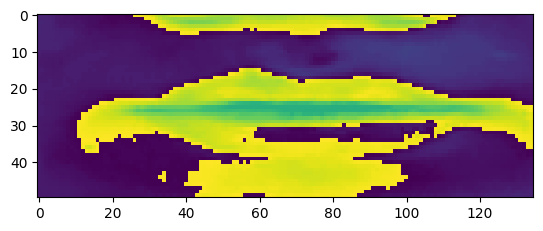

In [232]:
plt.imshow(frames[70])

In [233]:
alignments

<tf.Tensor: shape=(14,), dtype=int64, numpy=array([26,  1,  1, 14, 35, 39,  8, 15, 21, 31, 39,  4, 15, 30])>

In [234]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'zaan6 hou2 do1'>

In [235]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

2. Create Data Pipeline

In [236]:
from matplotlib import pyplot as plt

In [237]:
data = tf.data.Dataset.list_files('./data_cantonese/s1/*.mp4')
data = data.shuffle(160, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[20]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
# Determine the sizes for training and testing sets
total_samples = 80
train_size = int(0.8 * total_samples)

# Split the data
train_data = data.take(train_size)
test_data = data.skip(train_size)

In [238]:
# for frames, target_sequence in data:
#     print("Target Sequence Length:", tf.shape(target_sequence)[1])


In [239]:
for sample in data:  # Adjust the number of samples to print
    video_frames, label = sample
    # print(video_frames.shape)
    if(video_frames.shape[1] > 75):
        # print("No. of frames:", video_frames.shape[1])
        print("Video Frames Shape:", video_frames.shape)
        print("Label:", label.numpy())
        print("~" * 50)

In [240]:
# Assuming `data` is your dataset
print("Element Spec:")
print(data.element_spec)

# Access the padded_shapes attribute for each element
for element_spec in data.element_spec:
    if isinstance(element_spec, tuple) and len(element_spec) == 2:
        print("Padded Shape:", element_spec[1])


Element Spec:
(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))


In [241]:
frames, alignments = data.as_numpy_iterator().next()

In [242]:
data.as_numpy_iterator().next()

(array([[[[[0.90545714],
           [0.90545714],
           [0.90545714],
           ...,
           [0.90545714],
           [0.9557603 ],
           [0.9557603 ]],
 
          [[0.90545714],
           [0.90545714],
           [0.90545714],
           ...,
           [0.9557603 ],
           [0.9557603 ],
           [0.9557603 ]],
 
          [[0.90545714],
           [0.90545714],
           [0.90545714],
           ...,
           [0.90545714],
           [0.9557603 ],
           [0.9557603 ]],
 
          ...,
 
          [[0.80485076],
           [0.7545476 ],
           [0.70424443],
           ...,
           [0.10060634],
           [0.10060634],
           [0.10060634]],
 
          [[0.90545714],
           [0.855154  ],
           [0.80485076],
           ...,
           [0.25151587],
           [0.25151587],
           [0.25151587]],
 
          [[0.9557603 ],
           [0.855154  ],
           [0.80485076],
           ...,
           [0.40242538],
           [0.40242538

In [243]:
len(frames)

2

In [244]:
sample = data.as_numpy_iterator()

In [245]:
val = sample.next(); val[0]

array([[[[[ 0.6393495 ],
          [ 0.6393495 ],
          [ 0.6393495 ],
          ...,
          [ 0.4110104 ],
          [ 0.4110104 ],
          [ 0.5023461 ]],

         [[ 0.8220208 ],
          [ 0.8220208 ],
          [ 0.8220208 ],
          ...,
          [ 0.4110104 ],
          [ 0.4110104 ],
          [ 0.5023461 ]],

         [[ 1.05036   ],
          [ 1.0046922 ],
          [ 0.9590243 ],
          ...,
          [ 0.4110104 ],
          [ 0.5023461 ],
          [ 0.5480139 ]],

         ...,

         [[ 0.5936817 ],
          [ 0.5480139 ],
          [ 0.5480139 ],
          ...,
          [ 0.13700348],
          [ 0.13700348],
          [ 0.13700348]],

         [[ 0.5936817 ],
          [ 0.5480139 ],
          [ 0.5480139 ],
          ...,
          [ 0.13700348],
          [ 0.13700348],
          [ 0.1826713 ]],

         [[ 0.5936817 ],
          [ 0.5480139 ],
          [ 0.5480139 ],
          ...,
          [ 0.1826713 ],
          [ 0.1826713 ],
          

In [246]:
len(val[0])

2

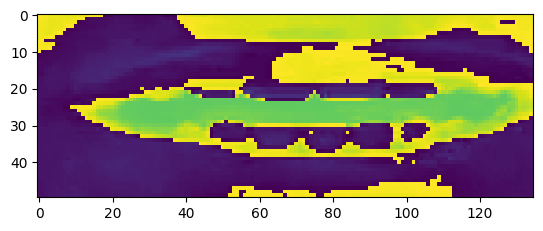

In [247]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][20])

In [248]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'zan1 waa6 laa1'>

3.Design the Deep Neural Network

In [249]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [250]:
data.as_numpy_iterator().next()[0][0].shape

(75, 50, 135, 1)

In [251]:
def create_lip_reading_model(input_shape, num_classes):
    model = Sequential()
    
    # model.add(Masking(mask_value=0.0, input_shape=input_shape))
    model.add(Conv3D(128, 3, input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1, 2, 2)))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, kernel_initializer='he_normal', activation='softmax'))

    return model


In [252]:
input_shape = (75,50,135,1)  # Modify based on actual input shape
num_classes =  char_to_num.vocabulary_size()+1 # Replace with the actual number of classes

In [253]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [254]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [255]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset
        self.dataset_iterator = None
    
    def on_epoch_begin(self, epoch, logs=None) -> None:
        # Create a new iterator at the beginning of each epoch
        self.dataset_iterator = self.dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        # Get the next batch of data from the iterator
        data = self.dataset_iterator.next()

        # Make predictions using the trained model
        yhat = self.model.predict(data[0])

        # Decode the predicted sequences using CTC decoding
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)

In [256]:
from tensorflow.keras.models import load_model
custom_objects = {'CTCLoss': CTCLoss}
checkpoint_directory = './saved_models'
# Ensure the checkpoint directory exists; if not, create it
os.makedirs(checkpoint_directory, exist_ok=True)
# Specify the checkpoint file path
checkpoint_path = os.path.join(checkpoint_directory, 'checkpoint')
# Check if there is a checkpoint file
if os.path.exists(checkpoint_path):
    print("Checkpoint exists in models.")
    # model = create_lip_reading_model(input_shape, num_classes)
    model = load_model(checkpoint_path,  custom_objects=custom_objects)
     # Retrieve the last epoch from the training history
    last_epoch = max(model.history.epoch) + 1 if hasattr(model.history, 'epoch') else 1
    # model.load_weights(checkpoint_path)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=CTCLoss)
    checkpoint_callback = ModelCheckpoint(
    os.path.join('saved_models','checkpoint'),
    monitor='loss', 
    save_weights_only=False, 
    save_freq='epoch', 
    save_format='h5') 
    print(f"Model loaded from checkpoint. Continue training from epoch {last_epoch}.")
    schedule_callback = LearningRateScheduler(scheduler)
    example_callback = ProduceExample(test_data)
    model.fit(train_data, validation_data=test_data, epochs=80, 
              callbacks=[checkpoint_callback, schedule_callback, example_callback],
              initial_epoch=last_epoch)
else:
    # If there is no checkpoint, create a new model
    # input_shape = (100, 100, 720, 1)  # Modify based on your actual input shape
    # num_classes =  char_to_num.vocabulary_size()+1 # Replace with the actual number of classes
    model = create_lip_reading_model(input_shape, num_classes)
    print("No checkpoint found. Creating a new model.")


No checkpoint found. Creating a new model.


In [257]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 50, 135, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 50, 135, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 25, 67, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 25, 67, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 25, 67, 256)   0         
                                                      

In [258]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [259]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb999999'>

In [260]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb999999'>

In [261]:
model.input_shape

(None, 75, 50, 135, 1)

In [262]:
model.output_shape

(None, 75, 41)

In [263]:
# from tensorflow.keras.utils import plot_model

# # Assuming 'model' is your neural network
# plot_model(model, to_file='model_network.png', show_shapes=True, show_layer_names=True)


4. Setup Training Options and Train

In [264]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
, loss=CTCLoss)

In [265]:
# print("Number of sequences in the batch:", batch_len.numpy())

In [266]:
checkpoint_callback = ModelCheckpoint(
    os.path.join('saved_models','checkpoint'),
    monitor='loss', 
    save_weights_only=False, 
    save_freq='epoch', 
    save_format='h5') 

In [267]:
schedule_callback = LearningRateScheduler(scheduler)

In [268]:
example_callback = ProduceExample(test_data)

In [269]:
model.fit(train_data, validation_data=test_data, epochs=80, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/80
64/64 [==============================] - ETA: 0s - loss: 68.3885INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 2s 2s/step
Original: waan4 dak1 hoi1
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 zing3 soeng4
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 384s 6s/step - loss: 68.3885 - val_loss: 59.4758 - lr: 1.0000e-04
Epoch 2/80
64/64 [==============================] - ETA: 0s - loss: 56.6851INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1000ms/step
Original: hou2 gam2 ze6
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zoi3 gin3 laa1
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 349s 5s/step - loss: 56.6851 - val_loss: 58.0353 - lr: 1.0000e-04
Epoch 3/80
64/64 [==============================] - ETA: 0s - loss: 52.0447INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: zoek3 faai3 lok6
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gong2 dak1 hou2
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 52.0447 - val_loss: 51.6758 - lr: 1.0000e-04
Epoch 4/80
64/64 [==============================] - ETA: 0s - loss: 48.5463INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: zan1 hai6 hou2
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 dak1 ji3
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 345s 5s/step - loss: 48.5463 - val_loss: 46.1656 - lr: 1.0000e-04
Epoch 5/80
64/64 [==============================] - ETA: 0s - loss: 46.6796INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: jau5 mou5 man6
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: m4 goi1 bong1 sau2
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 337s 5s/step - loss: 46.6796 - val_loss: 48.4742 - lr: 1.0000e-04
Epoch 6/80
64/64 [==============================] - ETA: 0s - loss: 46.3885INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 988ms/step
Original: zou2 san4 aa3
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: mou5 co3 laa1
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 335s 5s/step - loss: 46.3885 - val_loss: 49.5051 - lr: 1.0000e-04
Epoch 7/80
64/64 [==============================] - ETA: 0s - loss: 45.2340INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 991ms/step
Original: hou2 hok6 zaap6
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zoek3 hou2 wan6
Prediction:  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 342s 5s/step - loss: 45.2340 - val_loss: 45.1201 - lr: 1.0000e-04
Epoch 8/80
64/64 [==============================] - ETA: 0s - loss: 45.1392INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 984ms/step
Original: gong2 je5 laa1
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: oi3 do1 di1
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 336s 5s/step - loss: 45.1392 - val_loss: 43.0175 - lr: 1.0000e-04
Epoch 9/80
64/64 [==============================] - ETA: 0s - loss: 44.9196INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 988ms/step
Original: m4 ji3 si1
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zaan6 hou2 do1
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 337s 5s/step - loss: 44.9196 - val_loss: 45.0666 - lr: 1.0000e-04
Epoch 10/80
64/64 [==============================] - ETA: 0s - loss: 44.3878INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 998ms/step
Original: zan1 waa6 laa1
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: dak1 ji3 aa3
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 337s 5s/step - loss: 44.3878 - val_loss: 42.2577 - lr: 1.0000e-04
Epoch 11/80
64/64 [==============================] - ETA: 0s - loss: 44.6147INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 997ms/step
Original: zoi3 gin3 laa1
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gong2 dak1 hou2
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 44.6147 - val_loss: 42.3914 - lr: 1.0000e-04
Epoch 12/80
64/64 [==============================] - ETA: 0s - loss: 44.1862INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: nei5 hou2 maa3
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jat1 cai4 hang4
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 338s 5s/step - loss: 44.1862 - val_loss: 43.4313 - lr: 1.0000e-04
Epoch 13/80
64/64 [==============================] - ETA: 0s - loss: 43.4245INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: do1 ze6 nei5
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ze6 bong1 mong6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 343s 5s/step - loss: 43.4245 - val_loss: 43.1410 - lr: 1.0000e-04
Epoch 14/80
64/64 [==============================] - ETA: 0s - loss: 43.6750INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: ze6 bong1 mong6
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ni1 dou6 hai6
Prediction: a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 43.6750 - val_loss: 41.8875 - lr: 1.0000e-04
Epoch 15/80
64/64 [==============================] - ETA: 0s - loss: 42.9808INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: ting1 ming4 baak3
Prediction: o a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hing1 fan5 aa3
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 42.9808 - val_loss: 43.2261 - lr: 1.0000e-04
Epoch 16/80
64/64 [==============================] - ETA: 0s - loss: 43.2363INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: oi3 nei5 dei6
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hok6 zaap6
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 338s 5s/step - loss: 43.2363 - val_loss: 43.3094 - lr: 1.0000e-04
Epoch 17/80
64/64 [==============================] - ETA: 0s - loss: 42.6152INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: ping4 faai3 lok6
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 sik6 gwo3
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 42.6152 - val_loss: 43.4568 - lr: 1.0000e-04
Epoch 18/80
64/64 [==============================] - ETA: 0s - loss: 42.3892INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hai6 ni1 dou6
Prediction: o 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: oi3 nei5 dei6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 42.3892 - val_loss: 41.0188 - lr: 1.0000e-04
Epoch 19/80
64/64 [==============================] - ETA: 0s - loss: 41.9923INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 waan4 ge3
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bong1 hou2 jan4
Prediction: ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 41.9923 - val_loss: 41.5650 - lr: 1.0000e-04
Epoch 20/80
64/64 [==============================] - ETA: 0s - loss: 41.9062INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: m4 goi1 man6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 jau1 sik1
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 41.9062 - val_loss: 40.4041 - lr: 1.0000e-04
Epoch 21/80
64/64 [==============================] - ETA: 0s - loss: 41.4941INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: waan2 dak1 hoi1
Prediction: o a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sing4 jat6 gam2
Prediction: ha a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 41.4941 - val_loss: 40.4107 - lr: 1.0000e-04
Epoch 22/80
64/64 [==============================] - ETA: 0s - loss: 40.9006INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 gam2 ze6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: m4 dou3 sau2
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 40.9006 - val_loss: 39.5047 - lr: 1.0000e-04
Epoch 23/80
64/64 [==============================] - ETA: 0s - loss: 40.4706INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 990ms/step
Original: jat1 cai4 hang4
Prediction: ha a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 siu3
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 40.4706 - val_loss: 40.8787 - lr: 1.0000e-04
Epoch 24/80
64/64 [==============================] - ETA: 0s - loss: 40.1349INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: zan1 hai6 hou2
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: m4 goi1 man6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 342s 5s/step - loss: 40.1349 - val_loss: 38.9553 - lr: 1.0000e-04
Epoch 25/80
64/64 [==============================] - ETA: 0s - loss: 39.6423INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: m4 haak3 hei3
Prediction: ha 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sing4 jat6 gam2
Prediction: ha 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 39.6423 - val_loss: 38.2779 - lr: 1.0000e-04
Epoch 26/80
64/64 [==============================] - ETA: 0s - loss: 38.8388INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 hou2 teng1
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: cing2 man6 laa1
Prediction: ha a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 38.8388 - val_loss: 40.0612 - lr: 1.0000e-04
Epoch 27/80
64/64 [==============================] - ETA: 0s - loss: 38.8159INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: zan1 waa6 laa1
Prediction: ha a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 mou5 man6 tai4
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 38.8159 - val_loss: 38.1841 - lr: 1.0000e-04
Epoch 28/80
64/64 [==============================] - ETA: 0s - loss: 38.1522INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 992ms/step
Original: gong2 zan1 waa6
Prediction: ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: mou5 man6 tai4
Prediction: ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 337s 5s/step - loss: 38.1522 - val_loss: 36.7898 - lr: 1.0000e-04
Epoch 29/80
64/64 [==============================] - ETA: 0s - loss: 38.0940INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: m4 goi1 man6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 aa3
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 38.0940 - val_loss: 36.7345 - lr: 1.0000e-04
Epoch 30/80
64/64 [==============================] - ETA: 0s - loss: 37.7935INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: zou2 san4 aa3
Prediction: ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jat1 cai4 gaa1
Prediction: a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 37.7935 - val_loss: 36.1939 - lr: 1.0000e-04
Epoch 31/80
64/64 [==============================] - ETA: 0s - loss: 36.6496INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1000ms/step
Original: mou5 gam2 ji6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: maan6 maan6 zau2
Prediction: ma
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 36.6496 - val_loss: 34.4644 - lr: 9.0484e-05
Epoch 32/80
64/64 [==============================] - ETA: 0s - loss: 35.9404INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: bong1 ngo5 gong2
Prediction: hong
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 mou5 man6
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 338s 5s/step - loss: 35.9404 - val_loss: 34.3304 - lr: 8.1873e-05
Epoch 33/80
64/64 [==============================] - ETA: 0s - loss: 34.6189INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 989ms/step
Original: hing1 fan5 aa3
Prediction: ha a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zoi3 gin3 laa1
Prediction: ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 34.6189 - val_loss: 33.9498 - lr: 7.4082e-05
Epoch 34/80
64/64 [==============================] - ETA: 0s - loss: 34.5196INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: ceoi4 bin1 laa1
Prediction: ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 dak1 ji3
Prediction: hou2 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 34.5196 - val_loss: 32.1701 - lr: 6.7032e-05
Epoch 35/80
64/64 [==============================] - ETA: 0s - loss: 33.8741INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: mou5 gam2 ji6
Prediction: hou m
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 aa3
Prediction: ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 343s 5s/step - loss: 33.8741 - val_loss: 31.8814 - lr: 6.0653e-05
Epoch 36/80
64/64 [==============================] - ETA: 0s - loss: 33.0290INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 hok6 zaap6
Prediction: hou a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 waan4 ge3
Prediction: hou a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 342s 5s/step - loss: 33.0290 - val_loss: 30.2596 - lr: 5.4881e-05
Epoch 37/80
64/64 [==============================] - ETA: 0s - loss: 32.4452INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: bong1 m4 dou3
Prediction: mo o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 dak1 ji3
Prediction: hou2 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 32.4452 - val_loss: 30.5601 - lr: 4.9659e-05
Epoch 38/80
64/64 [==============================] - ETA: 0s - loss: 31.5261INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hoi1 sam1 o1
Prediction: ho 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zoek3 faai3 lok6
Prediction: ho a o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 31.5261 - val_loss: 29.9842 - lr: 4.4933e-05
Epoch 39/80
64/64 [==============================] - ETA: 0s - loss: 31.0449INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: soeng4 gam2 ze6
Prediction: hong g 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 aa3
Prediction: ho1 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 31.0449 - val_loss: 28.5088 - lr: 4.0657e-05
Epoch 40/80
64/64 [==============================] - ETA: 0s - loss: 30.5550INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: mou5 man6 tai4
Prediction: mouma
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: mou5 gam2 ji6
Prediction: hou m 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 30.5550 - val_loss: 27.9359 - lr: 3.6788e-05
Epoch 41/80
64/64 [==============================] - ETA: 0s - loss: 29.8549INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: gong2 zan1 waa6
Prediction: hon a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bong1 ngo5 gong2
Prediction: hong og
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 29.8549 - val_loss: 27.7401 - lr: 3.3287e-05
Epoch 42/80
64/64 [==============================] - ETA: 0s - loss: 29.4745INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 990ms/step
Original: hou2 dak1 ji3
Prediction: hou2 a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gong2 je5 laa1
Prediction: on2 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 29.4745 - val_loss: 27.2223 - lr: 3.0119e-05
Epoch 43/80
64/64 [==============================] - ETA: 0s - loss: 29.0492INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 995ms/step
Original: san1 fu5 nei5
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gong2 je5 laa1
Prediction: gon2 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 336s 5s/step - loss: 29.0492 - val_loss: 26.2040 - lr: 2.7253e-05
Epoch 44/80
64/64 [==============================] - ETA: 0s - loss: 28.8069INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: gong2 je5 laa1
Prediction: gog a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gong2 dak1 hou2
Prediction: hog 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 338s 5s/step - loss: 28.8069 - val_loss: 26.5193 - lr: 2.4660e-05
Epoch 45/80
64/64 [==============================] - ETA: 0s - loss: 28.1243INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: soeng4 gam2 ze6
Prediction: hong g 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hoi1 sam1
Prediction: hou2 ho a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 28.1243 - val_loss: 25.9971 - lr: 2.2313e-05
Epoch 46/80
64/64 [==============================] - ETA: 0s - loss: 27.5780INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: waan2 dak1 hoi1
Prediction: a h
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: dak1 ji3 ge3
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 27.5780 - val_loss: 26.4032 - lr: 2.0190e-05
Epoch 47/80
64/64 [==============================] - ETA: 0s - loss: 27.8260INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 zing3 soeng4
Prediction: hou2 g
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jat1 nou5 lik6
Prediction: ja 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 342s 5s/step - loss: 27.8260 - val_loss: 25.9065 - lr: 1.8268e-05
Epoch 48/80
64/64 [==============================] - ETA: 0s - loss: 27.4476INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: jat1 cai4 lei4
Prediction: a a e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zoek3 faai3 lok6
Prediction: ho a o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 336s 5s/step - loss: 27.4476 - val_loss: 25.8746 - lr: 1.6530e-05
Epoch 49/80
64/64 [==============================] - ETA: 0s - loss: 27.0571INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: m4 haak3 hei3
Prediction: ma
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zou2 san4 aa3
Prediction: hou2 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 337s 5s/step - loss: 27.0571 - val_loss: 25.6901 - lr: 1.4957e-05
Epoch 50/80
64/64 [==============================] - ETA: 0s - loss: 26.8748INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: m4 haak3 hei3
Prediction: ma a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: m4 hai6 aa3
Prediction: ma a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 26.8748 - val_loss: 24.4649 - lr: 1.3534e-05
Epoch 51/80
64/64 [==============================] - ETA: 0s - loss: 26.7783INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: mou5 man6 tai4
Prediction: mou ma
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: m4 do1 ze6
Prediction: m e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 26.7783 - val_loss: 23.9252 - lr: 1.2246e-05
Epoch 52/80
64/64 [==============================] - ETA: 0s - loss: 26.7349INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 gam2 ze6
Prediction: hou2 e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gong2 m4 ceot1
Prediction: og 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 26.7349 - val_loss: 23.2810 - lr: 1.1080e-05
Epoch 53/80
64/64 [==============================] - ETA: 0s - loss: 26.4596INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hoi1 sam1 lei4
Prediction: hoi1 ae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 sik6 gwo3
Prediction: ja 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 342s 5s/step - loss: 26.4596 - val_loss: 24.1567 - lr: 1.0026e-05
Epoch 54/80
64/64 [==============================] - ETA: 0s - loss: 26.6573INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1000ms/step
Original: on1 hei2 lok6
Prediction: ho h o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bong1 m4 dou3
Prediction: mon m o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 26.6573 - val_loss: 24.3025 - lr: 9.0718e-06
Epoch 55/80
64/64 [==============================] - ETA: 0s - loss: 26.1790INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: ting1 ming4 baak3
Prediction: zin g a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ceoi4 bin1 laa1
Prediction: hoi i a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 338s 5s/step - loss: 26.1790 - val_loss: 23.2880 - lr: 8.2085e-06
Epoch 56/80
64/64 [==============================] - ETA: 0s - loss: 26.2850INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hoi1 sam1 ge3
Prediction: hoi sa1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zan1 hai6 ge3
Prediction: a i
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 26.2850 - val_loss: 23.9027 - lr: 7.4274e-06
Epoch 57/80
64/64 [==============================] - ETA: 0s - loss: 25.9992INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: gong2 zan1 ze1
Prediction: gng 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: jau5 mou5 man6
Prediction: ma ou a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 343s 5s/step - loss: 25.9992 - val_loss: 24.3012 - lr: 6.7206e-06
Epoch 58/80
64/64 [==============================] - ETA: 0s - loss: 26.0121INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hai6 ge3 ze1
Prediction: hai e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hok6 zaap6
Prediction: hou2 ha
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 344s 5s/step - loss: 26.0121 - val_loss: 23.5609 - lr: 6.0810e-06
Epoch 59/80
64/64 [==============================] - ETA: 0s - loss: 25.8597INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: do1 ze6 nei5
Prediction: o e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 jau1 sik1
Prediction: hou2 i
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 349s 5s/step - loss: 25.8597 - val_loss: 23.4134 - lr: 5.5023e-06
Epoch 60/80
64/64 [==============================] - ETA: 0s - loss: 25.6918INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: jat1 cai4 hang4
Prediction: ja a n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hoi1 sam1
Prediction: hou oi a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 25.6918 - val_loss: 22.9091 - lr: 4.9787e-06
Epoch 61/80
64/64 [==============================] - ETA: 0s - loss: 25.8243INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: gong2 zan1 ze1
Prediction: gng 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: mou5 co3 laa1
Prediction: mou a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 25.8243 - val_loss: 23.3593 - lr: 4.5049e-06
Epoch 62/80
64/64 [==============================] - ETA: 0s - loss: 25.6203INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 972ms/step
Original: faai3 di1 laa1
Prediction: a i1 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 lei4
Prediction: ho1 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 338s 5s/step - loss: 25.6203 - val_loss: 22.8876 - lr: 4.0762e-06
Epoch 63/80
64/64 [==============================] - ETA: 0s - loss: 25.7632INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 geng1 aa3
Prediction: hou ga
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zan1 hai6 hou2
Prediction: a haho
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 338s 5s/step - loss: 25.7632 - val_loss: 22.2360 - lr: 3.6883e-06
Epoch 64/80
64/64 [==============================] - ETA: 0s - loss: 25.5624INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: oi3 nei5 dei6
Prediction: oi e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bong1 m4 dou3
Prediction: mon o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 25.5624 - val_loss: 22.0270 - lr: 3.3373e-06
Epoch 65/80
64/64 [==============================] - ETA: 0s - loss: 25.3906INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hai6 ni1 dou6
Prediction: hai d
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zou2 tou2 aa3
Prediction: hou2 o2a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 339s 5s/step - loss: 25.3906 - val_loss: 24.0675 - lr: 3.0197e-06
Epoch 66/80
64/64 [==============================] - ETA: 0s - loss: 25.3891INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 999ms/step
Original: gong2 je5 laa1
Prediction: gog2 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: tai2 haa5 laa1
Prediction: a a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 25.3891 - val_loss: 23.3347 - lr: 2.7324e-06
Epoch 67/80
64/64 [==============================] - ETA: 0s - loss: 25.3468INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1000ms/step
Original: ngam1 ngam1 lei4
Prediction: ma1 mam
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hou2 teng1
Prediction: hou2 ou n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 336s 5s/step - loss: 25.3468 - val_loss: 23.4084 - lr: 2.4724e-06
Epoch 68/80
64/64 [==============================] - ETA: 0s - loss: 25.0803INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 993ms/step
Original: sing4 jat6 gam2
Prediction: mn a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: dak1 ji3 ge3
Prediction: a 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 338s 5s/step - loss: 25.0803 - val_loss: 22.9825 - lr: 2.2371e-06
Epoch 69/80
64/64 [==============================] - ETA: 0s - loss: 25.3444INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 geng1 hei2
Prediction: hou2 g 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 waan4 ge3
Prediction: hou2 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 337s 5s/step - loss: 25.3444 - val_loss: 23.8460 - lr: 2.0242e-06
Epoch 70/80
64/64 [==============================] - ETA: 0s - loss: 25.0132INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: ngo5 oi3 nei5
Prediction: o i
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: siu2 sam1 di1
Prediction: hou m
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 25.0132 - val_loss: 22.2289 - lr: 1.8316e-06
Epoch 71/80
64/64 [==============================] - ETA: 0s - loss: 25.1548INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: gong2 zan1 waa6
Prediction: hog a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 lei4
Prediction: ho1 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 337s 5s/step - loss: 25.1548 - val_loss: 22.6910 - lr: 1.6573e-06
Epoch 72/80
64/64 [==============================] - ETA: 0s - loss: 25.0696INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 991ms/step
Original: gong2 zan1 ze1
Prediction: gng 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zoek3 faai3 lok6
Prediction: ho a o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 338s 5s/step - loss: 25.0696 - val_loss: 23.0327 - lr: 1.4996e-06
Epoch 73/80
64/64 [==============================] - ETA: 0s - loss: 25.0602INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: oi3 nei5 dei6
Prediction: oi e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: m4 ji3 si1
Prediction: m s
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 25.0602 - val_loss: 21.9039 - lr: 1.3569e-06
Epoch 74/80
64/64 [==============================] - ETA: 0s - loss: 25.6493INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: faai3 di1 laa1
Prediction: ai a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hoi1 sam1 lei4
Prediction: ho1 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 340s 5s/step - loss: 25.6493 - val_loss: 22.9481 - lr: 1.2277e-06
Epoch 75/80
64/64 [==============================] - ETA: 0s - loss: 25.0160INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: hou2 geng1 hei2
Prediction: hou ge
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: hou2 hoi1 sam1
Prediction: hou o1 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 342s 5s/step - loss: 25.0160 - val_loss: 22.8481 - lr: 1.1109e-06
Epoch 76/80
64/64 [==============================] - ETA: 0s - loss: 25.0445INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: m4 hai6 aa3
Prediction: ma ha
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ngam1 ngam1 lei4
Prediction: ma1 mam
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 341s 5s/step - loss: 25.0445 - val_loss: 21.7759 - lr: 1.0052e-06
Epoch 77/80
64/64 [==============================] - ETA: 0s - loss: 24.7211INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: nei5 hou2 maa1
Prediction: hoi hou a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: gong2 dak1 hou2
Prediction: hog ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 337s 5s/step - loss: 24.7211 - val_loss: 22.4300 - lr: 9.0953e-07
Epoch 78/80
64/64 [==============================] - ETA: 0s - loss: 24.6873INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: zoek3 hou2 wan6
Prediction: ho hou 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: oi3 do1 di1
Prediction: o 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 356s 6s/step - loss: 24.6873 - val_loss: 23.0439 - lr: 8.2298e-07
Epoch 79/80
64/64 [==============================] - ETA: 0s - loss: 25.0033INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: zou2 san4 aa3
Prediction: hou2 a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: zoi3 gin3 laa1
Prediction: zo a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 342s 5s/step - loss: 25.0033 - val_loss: 22.4627 - lr: 7.4466e-07
Epoch 80/80
64/64 [==============================] - ETA: 0s - loss: 25.2594INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: saved_models/checkpoint/assets


1/1 [==============================] - 1s 1s/step
Original: zan1 waa6 laa1
Prediction: an a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: faai3 lok6 siu3
Prediction: a ok
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
64/64 [==============================] - 338s 5s/step - loss: 25.2594 - val_loss: 23.5732 - lr: 6.7380e-07


In [270]:
model.load_weights('saved_models/checkpoint')

2024-01-18 06:40:00.910788: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open saved_models/checkpoint: FAILED_PRECONDITION: saved_models/checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [271]:
test = test_data.as_numpy_iterator()

In [272]:
sample = test.next()

In [273]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 1s/step


In [274]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'hai6 ni1 dou6'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'hou2 hou2 teng1'>]

In [275]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [276]:
print('~'*100, 'PREDICTION')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTION


[<tf.Tensor: shape=(), dtype=string, numpy=b'hai'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'houo'>]

In [277]:
# model.save(os.path.join('models', 'final_model'))